# Random Forest Classifier - Iris Dataset
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/random_forest_iris.ipynb)

* Iris example adapted from: https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* Further modified by: Aaron Hill and Wei-Ting Hsiao (Dept. of Atmospheric Science, Colorado State University), January 2020
* Further adapted by: Prof. Elizabeth Barnes for ATS 655 and ATS 780A7 Spring 2022 at Colorado State University

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
import pydot

import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150


In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"scikit-learn version = {sklearn.__version__}")  

python version = 3.7.11 (default, Jul 27 2021, 07:03:16) 
[Clang 10.0.0 ]
numpy version = 1.21.5
scikit-learn version = 1.0.2


In [4]:
# Make the path of your own Google Drive accessible to save a figure
if IN_COLAB:
    try:
        from google.colab import drive
        drive.mount('/content/drive', force_remount=True)
        local_path = '/content/drive/My Drive/Colab Notebooks/'
    except:
        local_path = './'
else:
    local_path = '../figures/'

In [5]:
#Load dataset
iris = datasets.load_iris()

print('target/labels: ' + str(iris.target_names))
print('     features: ' + str(iris.feature_names))

target/labels: ['setosa' 'versicolor' 'virginica']
     features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [6]:
# create DataFrame so it looks nice for visualizing the data

data=pd.DataFrame({
    'sepal length':iris.data[:,0],
    'sepal width':iris.data[:,1],
    'petal length':iris.data[:,2],
    'petal width':iris.data[:,3],
    'species':iris.target
})
data.head()

,sepal length,sepal width,petal length,petal width,species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
# Split data into training and testing

X=data[['sepal length', 'sepal width', 'petal length', 'petal width']]  # Features
y=data['species']  # Labels

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # 70% training and 30% test

In [8]:
# Create and Train the Random Forest Classifier
#-------------------------------------------------------------------------------------------------
# MODIFY: important tunable parameters for model
number_of_trees = 30      # number of trees to "average" together to create a random forest
tree_depth = 3            # maximum depth allowed for each tree
node_split = 2            # minimum number of training samples needed to split a node
leaf_samples = 1          # minimum number of training samples required to make a leaf node
criterion = 'gini'        # 'gini' or 'entropy'
bootstrap = False         # whether to perform "bagging=bootstrap aggregating" or not
max_samples = None        # number of samples to grab when training each tree IF bootstrap=True, otherwise None
RAND_STATE = 17
#-------------------------------------------------------------------------------------------------

rf=RandomForestClassifier(n_estimators=number_of_trees,
                           criterion=criterion,     
                           random_state=RAND_STATE,
                           min_samples_split = node_split,
                           min_samples_leaf = leaf_samples,
                           max_depth = tree_depth,
                           bootstrap = bootstrap,
                           max_samples = max_samples,
                          )

# train the model using the training sets
rf.fit(X_train,y_train)

# make predictions on the test set
y_test_pred=rf.predict(X_test)
acc = metrics.accuracy_score(y_test, y_test_pred) # compute the accuracy on the test set
print("testing accuracy: ", np.around(acc*100), '%')

testing accuracy:  100.0 %


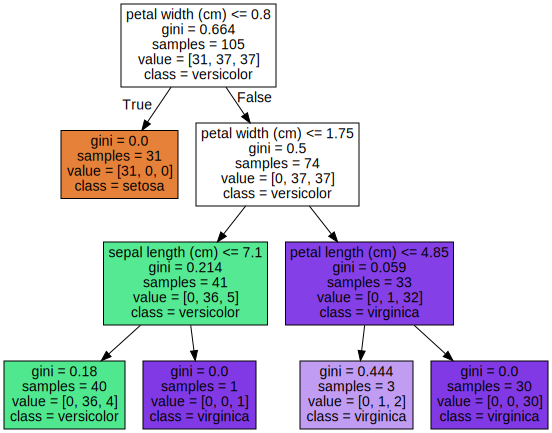

In [9]:
from graphviz import Source
fig_savename = 'RF_iris_tree'
tree = rf[-1]

export_graphviz(tree,
                out_file=local_path + '/' + fig_savename+'.dot',
                filled=True,
                proportion=False,
                leaves_parallel=False,
                class_names=iris.target_names,
                feature_names=iris.feature_names)

Source.from_file(local_path + fig_savename+'.dot')

### Feature Importance


Variable: petal width (cm)     Importance: 0.52
Variable: petal length (cm)    Importance: 0.4
Variable: sepal length (cm)    Importance: 0.07
Variable: sepal width (cm)     Importance: 0.01



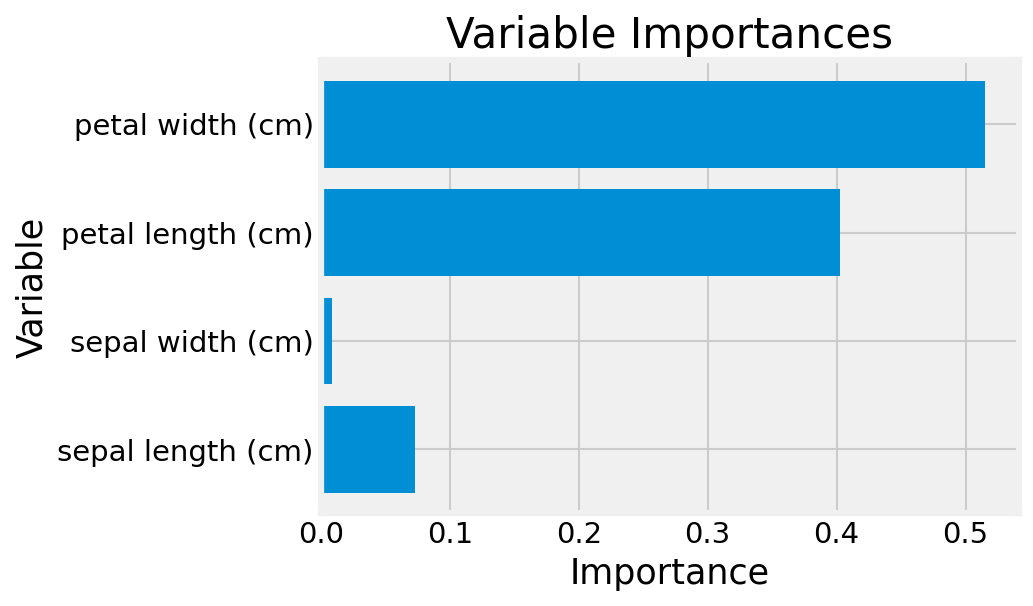

In [10]:
def calc_importances(rf, feature_list):

    # Get numerical feature importances
    importances = list(rf.feature_importances_)

    # List of tuples with variable and importance
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

    # Sort the feature importances by most important first
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

    # Print out the feature and importances 
    print('')
    [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]
    print('')

    return importances

def plot_feat_importances(importances, feature_list): 
    plt.figure()
    # Set the style
    plt.style.use('fivethirtyeight')
    # list of x locations for plotting
    x_values = list(range(len(importances)))
    # Make a bar chart
    plt.barh(x_values, importances)
    # Tick labels for x axis
    plt.yticks(x_values, feature_list)
    # Axis labels and title
    plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances')
    
    
plot_feat_importances(calc_importances(rf,  iris.feature_names),  iris.feature_names)

### Permutation Importance

In [11]:
# Single-pass permutation
permute = permutation_importance(rf, X, y, n_repeats=20, 
                                 random_state=RAND_STATE)

# Sort the importances
sorted_idx = permute.importances_mean.argsort()

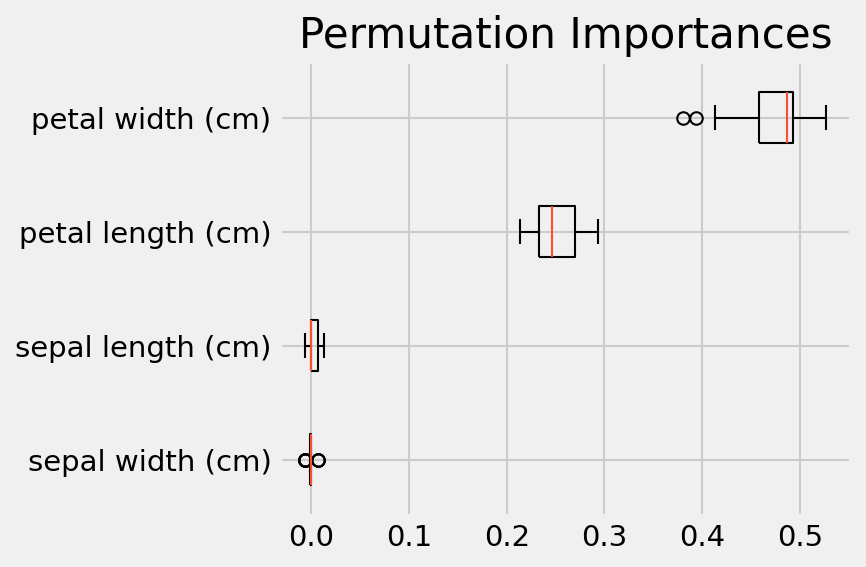

In [12]:
def plot_perm_importances(permute, sorted_idx, feature_list):
    # Sort the feature list based on 
    
    new_feature_list = []
    for index in sorted_idx:  
        new_feature_list.append(feature_list[index])

    fig, ax = plt.subplots()
    ax.boxplot(permute.importances[sorted_idx].T,
           vert=False, labels=new_feature_list)
    ax.set_title("Permutation Importances")
    fig.tight_layout()
    
plot_perm_importances(permute, sorted_idx, iris.feature_names)